In [3]:
# !pip install opencv-python
# !pip install pandas seaborn numpy matplotlib scikit-learn tifffile scikit-image tqdm opencv-python rasterio Pillow

# Imports

In [1]:
%%capture
!chmod -R 777 ../

In [1]:
# System and path operations
import sys
import os
import datetime
from pathlib import Path
from glob import glob
sys.path.insert(0, '../')

# Imported local modules
from src.config import *
from src.utils import *
from src.models_arch import *
from src.models_utils import *

# Basic python data handling and visualization libraries
import random
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time

# Libraries for image processing
from PIL import Image
import skimage
from skimage.io import imread, imsave
import tifffile as tiff

# Libraries for model evaluation and validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, jaccard_score, roc_curve, auc

# TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import keras
from keras import backend as K
from keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau, 
                             CSVLogger, EarlyStopping)
from keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from itertools import product
import numpy as np
from sklearn.metrics import jaccard_score

# Setting seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

2023-08-31 15:25:42.532186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 15:25:43.635252: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Setting GPU's number
physical_devices=tf.config.experimental.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [6]:
# tf.config.set_visible_devices(physical_devices[:],'GPU')
tf.config.set_visible_devices(physical_devices[2],'GPU')

In [7]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=10240)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [8]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [9]:
# %tensorboard --logdir logs/fit 

In [10]:
# Clear any logs from previous runs
# !rm -rf ../logs/
# !rm -rf ../models/

---

# Hyperparameter Selection and Model Configuration

In the following code snippet, we focus on the essential aspects of configuring a deep learning model for a specific task. The primary objective is to select appropriate hyperparameters and set up the model for training.

### Model Selection

The code allows for the selection of various deep learning models, including 'UNet', 'RSNet', 'UNetPlusPlus', 'CloudNet', 'CloudXNet', 'RSNet', and 'DLV3'. These models are tailored for different computer vision tasks, and here we prepare to use one of them as the foundation for our task.

Available models:
- 'unet'
- 'unet_plus_plus'
- 'rs_net'
- 'deep_lab_v3_plus'
- 'CXNet'
- 'cloud_net'

### Batch Size and Data Configuration

The batch size, a crucial hyperparameter that affects training efficiency and memory consumption, is set to 16. Additionally, there's an option to specify whether the training data includes RGB channels or both RGB and NIR channels, denoted as 'RGB' or 'RGBNIR', respectively.

### Learning Rate and Optimization

The learning rate, an essential hyperparameter for controlling the step size during optimization, is set to 1e-4. Different optimizers such as Adam, Nadam, SGD, and RMSprop are available for selection, each with its impact on training dynamics.

### Loss and Metrics

The code provides flexibility in choosing the loss function and evaluation metrics. Options include 'binary_crossentropy', 'BinaryFocalCrossentropy', custom loss functions like 'bce_dice_loss' and 'jacc_coef', as well as metrics such as 'AUC'.

### Model Initialization

The selected model is initialized using the chosen hyperparameters and configurations, setting the stage for further model training and evaluation.

---
Notes:
- DeepLabV3+, CXNen need resizing since a fixed image size is required for internal operations
- DeepLabV3+ and CXNet can only be trained with 3 channel images(RGB in our case) due to internal operations

In [3]:
# model_name = 'UNet'
# model_name = 'UNetPlusPlus'
# model_name = 'RSNet'
# model_name = 'CloudXNet'
model_name = 'CloudNet'
# model_name = 'DLV3'


# Define batch size
batch_size = 16

# Whether the images for the training should include the NIR channel or not
train_with_RGB = True

# learning rate
LR = 1e-4

NUM_EPOCHS=300

In [ ]:
s = 'RGB' if train_with_RGB else 'RGBNIR'

model_name = f'{model_name}_SPARCS_epochs{NUM_EPOCHS}_batch{batch_size}_{s}'

model_name

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
# optimizer = tf.keras.optimizers.Nadam(learning_rate=LR)
# optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=LR)

metrics = ['binary_crossentropy', tf.keras.losses.BinaryFocalCrossentropy(), bce_dice_loss, jacc_coef, tf.keras.metrics.AUC()]
# metrics = [jacc_coef, tf.keras.metrics.AUC()]


# loss = 'binary_crossentropy'
loss = jacc_coef
# loss = tf.keras.losses.BinaryFocalCrossentropy()
# loss = bce_dice_loss


model = create_model(model_name='unet')
# model = create_model(model_name='unet_plus_plus')
# model = create_model(model_name='rs_net')
# model = create_model(model_name='cloud_net', IMG_CHANNELS=3)
# model = create_model(model_name='CXNet', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
# model = create_model(model_name='deep_lab_v3_plus', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)

2023-08-30 22:40:21.863547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 22:40:22.344252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


# Data loading

## Generator

In [13]:
train_image_names = sorted(os.listdir(Path(sparcs_train_dir, "images_p/")))
valid_image_names = sorted(os.listdir(Path(sparcs_valid_dir, "images_p/")))
steps_per_epoch = math.ceil(len(train_image_names) / batch_size)
validation_steps = math.ceil(len(valid_image_names) / batch_size)
steps_per_epoch, validation_steps

(62, 8)

In [14]:
test_image_names = sorted(os.listdir(Path(sparcs_test_dir, "images_p/")))
total_test_samples = math.ceil(len(test_image_names) / batch_size)

In [15]:
train = get_SPARCS_generator('train', batch_size=batch_size, shuffle=True, only_rgb=train_with_RGB)
valid = get_SPARCS_generator('valid', batch_size=batch_size, only_rgb=train_with_RGB)
test = get_SPARCS_generator('test', batch_size=batch_size, only_rgb=train_with_RGB)

In [16]:
X_test, y_test = get_SPARCS('test', only_rgb=train_with_RGB)

Batch of Images shape: (16, 256, 256, 3)
Batch of Masks shape: (16, 256, 256, 1)


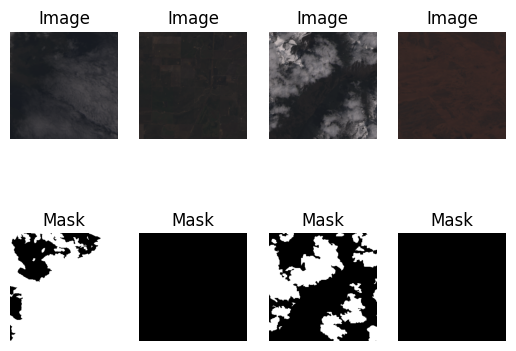

In [17]:
# Check the right functioning of the generator

# Step 1: Create and initialize the generator (example for the training set)
train_generator = get_SPARCS_generator('train', batch_size=16, shuffle=True, only_rgb=train_with_RGB)

# Step 2: Get a batch of data from the generator
batch_images, batch_masks = next(train_generator)

# Step 3: Print the shapes of the images and masks in the batch
print("Batch of Images shape:", batch_images.shape)
print("Batch of Masks shape:", batch_masks.shape)

# Step 4: Display some example images along with their masks
num_examples_to_display = 4
for i in range(num_examples_to_display):
    plt.subplot(2, num_examples_to_display, i + 1)
    plt.imshow(batch_images[i])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(2, num_examples_to_display, i + num_examples_to_display + 1)
    plt.imshow(batch_masks[i][:, :, 0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")

plt.show()

## tf.Data

In [17]:
train_image_size = len(sorted(os.listdir(Path(sparcs_train_dir, "images_p/"))))
valid_image_size = len(sorted(os.listdir(Path(sparcs_valid_dir, "images_p/"))))

In [18]:
train = tf.data.Dataset.from_tensor_slices(get_SPARCS(only_rgb=train_with_RGB))
valid = tf.data.Dataset.from_tensor_slices(get_SPARCS('valid', only_rgb=train_with_RGB))
test = tf.data.Dataset.from_tensor_slices(get_SPARCS('test', only_rgb=train_with_RGB))

train = train.shuffle(train_image_size, seed=seed_value).batch(batch_size)
valid = valid.shuffle(valid_image_size, seed=seed_value).batch(batch_size)
test = test.batch(batch_size)

In [19]:
X_test, y_test = get_SPARCS('test', only_rgb=train_with_RGB)

# Training

---

## Checkpoint and Callback Configuration

In this code segment, we configure essential aspects related to saving checkpoints and defining callbacks during the training of a deep learning model. These components are crucial for monitoring and optimizing the training process.

### Checkpoint Configuration

Checkpointing is essential to save the model's progress during training. This code defines checkpoint paths using `ckpt_path` and sets up the directory for saving checkpoints. A common practice is to save the best model based on validation loss. Thus, a ModelCheckpoint callback (`cp_callback`) is established to monitor the validation loss and save only the best-performing model weights.

### Logging and TensorBoard

The code also establishes a directory for logging training information using TensorBoard. This log directory, `log_dir`, includes details about model performance during training, such as loss curves and metrics over epochs. A TensorBoard callback (`tensorboard_callback`) is created to facilitate this logging.

### Time Tracking Callback

To keep track of the time taken for each training epoch, a custom callback named `TimeHistory` is defined. This callback records the time spent on each epoch, providing insights into the training duration.

### Early Stopping

Early stopping is a useful technique to prevent overfitting. An EarlyStopping callback (`early_stopping`) is set up to monitor the validation loss and halt training if it does not improve for a specified number of epochs (patience).

### Learning Rate Scheduling

Learning rate scheduling is incorporated via a ReduceLROnPlateau callback (`reduce_lr`). This callback monitors the validation loss and adjusts the learning rate during training to help converge to a better solution.

### Callbacks List

Finally, all defined callbacks (`cp_callback`, `time_callback`, `tensorboard_callback`, `reduce_lr`) are assembled into a list called `callbacks_list`. This list is then used during model training to execute the specified actions at different training stages.

---

These checkpointing and callback configurations are essential for effectively monitoring and managing the training process of deep learning models, ensuring that the best model is saved and providing valuable insights into training dynamics and performance.

In [19]:
# Include the epoch in the file name (uses `str.format`)
# ckpt_path = str(checkpoint_path / f"{model_name}/" / "cp-{epoch:04d}.ckpt")
ckpt_path = str(checkpoint_path / f"{model_name}/" / "best_model.ckpt")

ckpt_dir = os.path.dirname(ckpt_path)

log_dir = project_root_path / "logs/fit/" / model_name / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Checkpoint callbacks definition
# Save the checkpoint only if the validation loss is minimum
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path, 
    verbose=1, 
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_freq='epoch')

# Time callback definition
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, min_lr=0.00005)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, cooldown=0, patience=15, min_lr=1e-8, verbose=1)

In [20]:
# callbacks_list = [cp_callback, time_callback, tensorboard_callback, early_stopping, reduce_lr]
callbacks_list = [cp_callback, time_callback, tensorboard_callback, reduce_lr]

In [21]:
# Save the weights using the `checkpoint_path` format
model.save_weights(ckpt_path.format(epoch=0))

In [22]:
# Resume from checkpoint

# # Create a new model instance
# model = create_model(model_name='unet_plus_plus')

# # Try to load the latest checkpoint
# try:
#     latest = tf.train.latest_checkpoint(ckpt_dir)
#     latest_epoch = int(latest.split("-")[-1].split(".")[0])  # extract epoch number from the filename
#     model.load_weights(latest)
#     print(f"Loaded weights from {latest}")
# except Exception as e:
#     print("No checkpoint was found, starting training from scratch.")
#     latest_epoch = 0  # if no checkpoint was found, start from epoch 0

# # Now compile your model with optimizer and loss
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')  

# # Continue training the model
# # Here, epochs should be the final epoch number you want to reach and initial_epoch should be set to the epoch number where training last left off
# model.fit(train_dataset, epochs=total_epochs, initial_epoch=latest_epoch, callbacks=callbacks_list, validation_data=val_dataset)


## Tuner

Section used for the hyperparameter optimization of the model, it implements a simple grid search that tries a series of combinations and compute a score on the test set. The parameters of the model with the best score is printed.

Note: this section of code can be skipped if we alredy know the parameter of the model, otherwise you can easly setup the below parameters and perform the search. 

In [14]:
# Setup for the data and the model callbacks
train_image_names = sorted(os.listdir(Path(sparcs_train_dir, "images_p/")))
valid_image_names = sorted(os.listdir(Path(sparcs_valid_dir, "images_p/")))
steps_per_epoch = math.ceil(len(train_image_names) / batch_size)
validation_steps = math.ceil(len(valid_image_names) / batch_size)

train_with_RGB = False

callbacks_list = [reduce_lr, early_stopping]

(62, 8)

In [ ]:
def load(batch_size):
    train = get_SPARCS_generator('train', batch_size=batch_size, shuffle=True, only_rgb=train_with_RGB)
    valid = get_SPARCS_generator('valid', batch_size=batch_size, only_rgb=train_with_RGB)
    return train, valid

def train_and_evaluate_model(model, train_data, valid_data, NUM_EPOCHS):
    history = model.fit(train_data,
                    validation_data=valid_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS, 
                    verbose=1,)
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_thresholded = y_pred > 0.5

    y_true_f = y_test.astype('float32')
    y_pred_f = y_pred_thresholded.astype('float32')

    y_true_flatten = y_true_f.reshape(-1)
    y_pred_flatten = y_pred_f.reshape(-1)

    jaccard = jaccard_score(y_true_flatten, y_pred_flatten)
    return jaccard

def hyperparameter_search():
    optimizer_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.Nadam, tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop]
    loss_options = ['binary_crossentropy', 'binary_focal_crossentropy', bce_dice_loss, jacc_coef]
    learning_rates = [1e-3]
    # batch_sizes = [8,16,32]
    batch_sizes = [8,16]
    num_epochs_list = [20]

    best_jaccard = 0.0
    best_hyperparameters = {}

    for optimizer_class, loss_option, lr, batch_size, num_epochs in product(optimizer_options, loss_options, learning_rates, batch_sizes, num_epochs_list):
        optimizer = optimizer_class(learning_rate=lr)
        loss = loss_option
        
        train_data, valid_data = load(batch_size)
        # X_test, y_test = get_biome8('test', only_rgb=train_with_RGB)
        X_test, y_test = get_SPARCS('test', only_rgb=train_with_RGB)


        model_name = f'CustomModel_optimizer_{optimizer_class.__name__}_loss_{loss}_lr_{lr}_batch_{batch_size}_epochs_{num_epochs}'
        print("Started training model: ", model_name)
        
        # model = create_model(model_name='CXNet', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
        # model = create_model(model_name='deep_lab_v3_plus', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
        # model = create_model(model_name='unet_plus_plus')
        # model = create_model(model_name='rs_net')
        model = create_model(model_name='cloud_net')
        model = compile_model(model, optimizer=optimizer, loss=loss)

        history = train_and_evaluate_model(model, train_data, valid_data, num_epochs)

        jaccard = evaluate_model(model, X_test, y_test)
        if jaccard > best_jaccard:
            best_jaccard = jaccard
            best_hyperparameters = {
                'name': model_name,
                'optimizer': optimizer_class.__name__,
                'loss': loss,
                'learning_rate': lr,
                'batch_size': batch_size,
                'num_epochs': num_epochs
            }
            
        print(f"Finished training model: {model_name} with score: {jaccard}. Best score:{best_jaccard}")

    return best_hyperparameters, best_jaccard

In [ ]:
# Call the hyperparameter search function
best_hyperparameters, best_jaccard = hyperparameter_search()

In [18]:
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Jaccard Score:", best_jaccard)

# Unet++
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_Nadam_loss_binary_focal_crossentropy_lr_0.001_batch_16_epochs_20', 'optimizer': 'Nadam', 'loss': 'binary_focal_crossentropy', 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 20}
# Best Jaccard Score: 0.7121222120519126

# RS-net:
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_Nadam_loss_<function jacc_coef at 0x7f8c59d6fee0>_lr_0.001_batch_16_epochs_20', 'optimizer': 'Nadam', 'loss': <function jacc_coef at 0x7f8c59d6fee0>, 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 20}
# Best Jaccard Score: 0.7464787972981535

# DLV3+
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_Adam_loss_<function bce_dice_loss at 0x7f76eaf89820>_lr_0.001_batch_16_epochs_20', 'optimizer': 'Adam', 'loss': <function bce_dice_loss at 0x7f76eaf89820>, 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 20}
# Best Jaccard Score: 0.7865337639004822

# CXN:
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_Adam_loss_binary_crossentropy_lr_0.001_batch_16_epochs_20', 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 20}
# Best Jaccard Score: 0.666452691417021

# CN:
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_RMSprop_loss_<function bce_dice_loss at 0x7efc7b457940>_lr_0.001_batch_16_epochs_20', 'optimizer': 'RMSprop', 'loss': <function bce_dice_loss at 0x7efc7b457940>, 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 20}
# Best Jaccard Score: 0.7891547351729247

Best Hyperparameters:
{'name': 'CustomModel_optimizer_RMSprop_loss_<function bce_dice_loss at 0x7efc7b457940>_lr_0.001_batch_16_epochs_20', 'optimizer': 'RMSprop', 'loss': <function bce_dice_loss at 0x7efc7b457940>, 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 20}
Best Jaccard Score: 0.7891547351729247


## Compile

In [23]:
model = compile_model(model, optimizer=optimizer, metrics=metrics, loss=loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   4640        ['conv2d[0][0]']                 
                                32)                                                           

## Fit

In [24]:
# # Train the model and save the history
# history = model.fit(train, 
#                     epochs=NUM_EPOCHS,
#                     validation_data=valid,
#                     callbacks=callbacks_list,
#                     verbose=1,)

# Train the model and save the history. Generator version
history = model.fit(train,
                    validation_data=valid,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS, 
                    verbose=1,)

Epoch 1/300


2023-08-30 22:40:44.176880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


62/62 [==============================] - ETA: 0s - loss: 0.6616 - binary_crossentropy: 0.6980 - binary_focal_crossentropy: 0.5192 - bce_dice_loss: 0.8657 - jacc_coef: 0.6616 - auc: 0.7636
Epoch 1: val_loss improved from inf to 0.90326, saving model to /home/jupyter/notebooks/models/checkpoints/CloudNet_SPARCS_epochs300_batch16_RGB/best_model.ckpt
62/62 [==============================] - 31s 374ms/step - loss: 0.6616 - binary_crossentropy: 0.6980 - binary_focal_crossentropy: 0.5192 - bce_dice_loss: 0.8657 - jacc_coef: 0.6616 - auc: 0.7636 - val_loss: 0.9033 - val_binary_crossentropy: 0.4552 - val_binary_focal_crossentropy: 0.1822 - val_bce_dice_loss: 1.0532 - val_jacc_coef: 0.9033 - val_auc: 0.6063 - lr: 1.0000e-04
Epoch 2/300
62/62 [==============================] - ETA: 0s - loss: 0.5015 - binary_crossentropy: 0.6905 - binary_focal_crossentropy: 0.6421 - bce_dice_loss: 0.6900 - jacc_coef: 0.5015 - auc: 0.8664
Epoch 2: val_loss did not improve from 0.90326
62/62 [======================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



62/62 [==============================] - ETA: 0s - loss: 0.0738 - binary_crossentropy: 0.1356 - binary_focal_crossentropy: 0.1329 - bce_dice_loss: 0.1062 - jacc_coef: 0.0738 - auc: 0.9841
Epoch 175: val_loss did not improve from 0.29873
62/62 [==============================] - 21s 342ms/step - loss: 0.0738 - binary_crossentropy: 0.1356 - binary_focal_crossentropy: 0.1329 - bce_dice_loss: 0.1062 - jacc_coef: 0.0738 - auc: 0.9841 - val_loss: 0.3183 - val_binary_crossentropy: 0.6347 - val_binary_focal_crossentropy: 0.6294 - val_bce_dice_loss: 0.5143 - val_jacc_coef: 0.3183 - val_auc: 0.8875 - lr: 1.1765e-05
Epoch 176/300
62/62 [==============================] - ETA: 0s - loss: 0.0724 - binary_crossentropy: 0.1341 - binary_focal_crossentropy: 0.1314 - bce_dice_loss: 0.1047 - jacc_coef: 0.0724 - auc: 0.9842
Epoch 176: val_loss did not improve from 0.29873
62/62 [==============================] - 21s 340ms/step - loss: 0.0724 - binary_crossentropy: 0.1341 - binary_focal_crossentropy: 0.1314 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



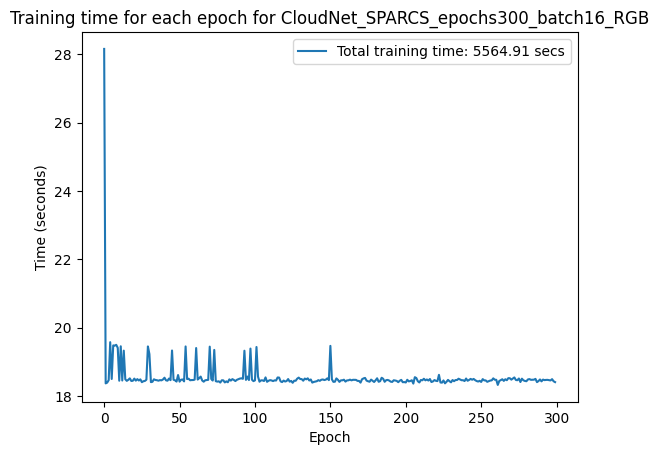

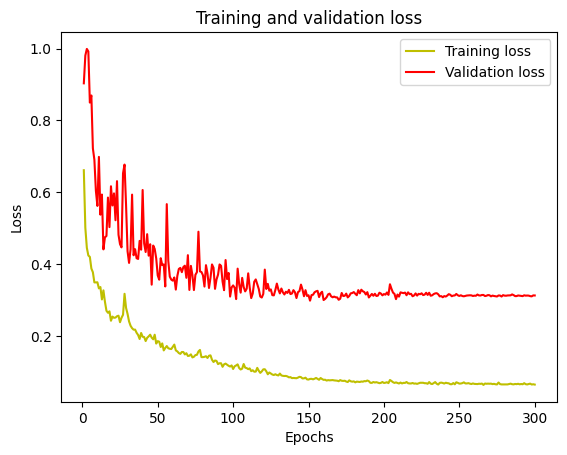

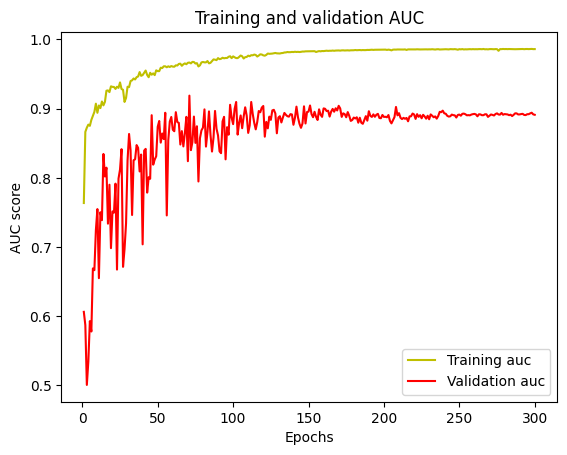

In [25]:
# Plot the training time for each epoch
plt.plot(time_callback.times, label=f'Total training time: {sum(time_callback.times):.2f} secs')
plt.ylabel('Time (seconds)')
plt.xlabel('Epoch')
plt.title(f'Training time for each epoch for {model_name}')
plt.legend()  

# Save the figure
plt.savefig(os.path.join(log_dir, 'training_time.png'))

plt.show()

# Plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title(f'Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the figure
plt.savefig(os.path.join(log_dir, 'loss.png'))

plt.show()

acc = history.history['auc']
val_acc = history.history['val_auc']
plt.plot(epochs, acc, 'y', label='Training auc')
plt.plot(epochs, val_acc, 'r', label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC score')
plt.legend()

# Save the figure
plt.savefig(os.path.join(log_dir, 'auc.png'))

plt.show()

## Save

In [34]:
# Convert float32 values to float
def convert_float32_to_float(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    return obj

In [35]:
# model.save(Path(saved_models_path, model_name))
model.save(Path(saved_models_path, f"{model_name}.h5"))

# Save training history
with open(Path(train_history_path, f'{model_name}.json'), 'w') as f:
    json.dump(history.history, f, default=convert_float32_to_float)

---

## Evaluation and Visualization of Model Performance

In the following code segment, we delve into the evaluation and visualization of a deep learning model's performance, particularly in the context of binary image segmentation tasks. The code includes the calculation of metrics such as the Jaccard Score (Intersection over Union or IoU) and the Receiver Operating Characteristic (ROC) curve. Additionally, it explores the impact of different threshold values on segmentation performance.

### Model Predictions and Thresholding

The code begins by making predictions using the trained model on a test dataset (`X_test`) and then applies a threshold of 0.5 to these predictions, converting them into binary masks (`y_pred_thresholded`). This thresholding step is a common practice in binary image segmentation tasks.

### Jaccard Score (IoU)

The Jaccard Score, also known as the IoU, is a crucial metric for evaluating segmentation accuracy. The code computes this score by comparing the flattened ground truth (`y_true`) and thresholded predicted masks (`thresholded_predictions`). The result is a measure of the spatial overlap between the predicted and actual binary masks.

### Receiver Operating Characteristic (ROC) Curve

The ROC curve and its associated Area Under the Curve (AUC) are employed to assess the model's ability to discriminate between positive and negative instances. The code calculates the ROC curve and AUC based on the true labels (`y_true`) and model scores (`y_score`). It then visualizes the ROC curve and highlights the AUC.

### Threshold Analysis

To understand how different threshold values affect segmentation performance, the code defines a range of threshold values (`thresholds`) to evaluate. It iterates through these thresholds, applies each threshold to the model's predictions, and calculates the Jaccard Score for each thresholded prediction. The results are plotted as a curve, illustrating how the Jaccard Score varies with different thresholds.

Overall, this code provides a comprehensive analysis of a model's segmentation performance, from evaluating spatial overlap using the Jaccard Score to assessing the model's ability to distinguish between classes via the ROC curve. The threshold analysis sheds light on the impact of different decision thresholds on the segmentation results.

--- 


In [36]:
y_test.shape
X_test.shape

(128, 256, 256, 3)

In [30]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

4/4 [==============================] - 2s 78ms/step


In [31]:
# Cast to float types
y_true_f = y_test.astype('float32')
y_pred_f = y_pred_thresholded.astype('float32')

y_true_flatten = y_true_f.reshape(-1)
y_pred_flatten = y_pred_f.reshape(-1)

# Jaccard Score
jaccard = jaccard_score(y_true_flatten, y_pred_flatten)
print("Jaccard Score (IoU): ", jaccard)

Jaccard Score (IoU):  0.681104595580554


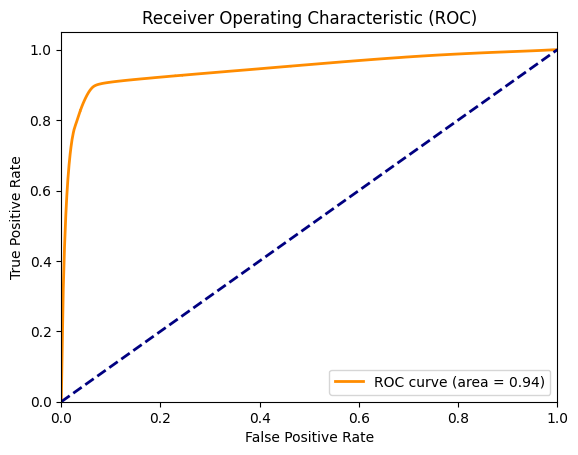

In [32]:
y_true = y_test.flatten()
y_score = y_pred.flatten()

fpr, tpr, _ = roc_curve(y_true, y_score)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Save the figure
plt.savefig(os.path.join(log_dir, 'roc.png'))

plt.show()


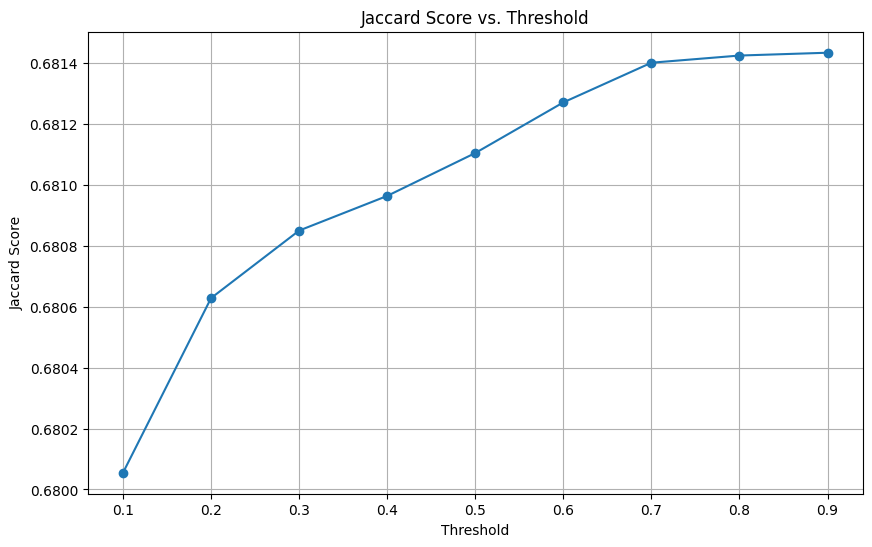

In [33]:
# Define your threshold values to evaluate
thresholds = np.linspace(0.1, 0.9, num=9)  # Adjust the range and step size as needed

# Initialize an empty list to store Jaccard scores
jaccard_scores = []

for threshold in thresholds:
    # Apply the threshold to the model's predictions
    thresholded_predictions = (y_score > threshold).astype(int)
    
    # Calculate the Jaccard score (IoU) for the thresholded predictions
    score = jaccard_score(y_true, thresholded_predictions)  # Adjust 'average' as needed
    
    jaccard_scores.append(score)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, jaccard_scores, marker='o', linestyle='-')
plt.title('Jaccard Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Jaccard Score')
plt.grid(True)

# Save the figure
plt.savefig(os.path.join(log_dir, 'threshold.png'))

plt.show()
